<a href="https://colab.research.google.com/github/tousifo/ml_notebooks/blob/main/OASIS_Alzheimer's_Detection%20using%20contrasive%20learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Install dependencies
!pip install torch torchvision scikit-learn numpy pillow opencv-python --quiet

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2

# Custom Dataset
class OASISDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        # Map actual directory names with spaces to labels
        class_mapping = {
            'Mild Dementia': 0,      # mild_demented
            'Moderate Dementia': 1,  # demented
            'Non Demented': 2,       # non_demented
            'Very mild Dementia': 3  # very_mild_demented
        }

        for class_name, label in class_mapping.items():
            class_dir = os.path.join(data_dir, class_name)
            if os.path.exists(class_dir):
                print(f"Found directory: {class_dir}")
                files = os.listdir(class_dir)
                print(f"Files in {class_dir}: {files}")
                for img_file in files:
                    if img_file.endswith('.jpg'):
                        img_path = os.path.join(class_dir, img_file)
                        self.images.append(img_path)
                        self.labels.append(label)
                        print(f"Added {img_path} with label {label}")
            else:
                print(f"Warning: Directory {class_dir} not found.")
        if not self.images:
            print("No .jpg files found in any class directories.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        try:
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = np.array(img)
            if self.transform:
                img = self.transform(img)
            return torch.from_numpy(img).float().unsqueeze(0), label  # Add channel dimension
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

# Preprocessing Function with Normalization
def preprocess_img(img):
    try:
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)  # Resize to 128x128
        img = img / 255.0  # Normalize to [0, 1]
        return img
    except Exception as e:
        print(f"Preprocessing error: {e}")
        return None

# Siamese Network for 2D Images
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),  # Adjusted for 128x128 input after pooling
            nn.ReLU(),
            nn.Linear(512, 4)  # 4 classes
        )

    def forward_once(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
criterion_ce = nn.CrossEntropyLoss()
criterion_gcat = nn.CosineEmbeddingLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)
alpha = 0.2

# Load and prepare dataset
data_dir = '/content/oasis_data/Data'  # Matches the provided path structure
dataset = OASISDataset(data_dir, transform=preprocess_img)
valid_data = []
for i in range(len(dataset)):
    img, label = dataset[i]
    if img is not None and label is not None:
        valid_data.append((img, label))
    else:
        print(f"Skipping invalid data at index {i}")

if not valid_data:
    print("No valid data found. Please check the dataset path and files after extraction.")
else:
    train_idx, val_idx = train_test_split(range(len(valid_data)), test_size=0.2, random_state=42)
    train_loader = DataLoader([valid_data[i] for i in train_idx], batch_size=12, shuffle=True)
    val_loader = DataLoader([valid_data[i] for i in val_idx], batch_size=12, shuffle=False)

    # Pair generation for contrastive learning
    def generate_pairs(batch_size, data):
        if len(data) < batch_size * 2:
            return None, None, None, None
        indices = np.random.choice(len(data), batch_size * 2, replace=False)
        imgs1 = torch.stack([data[i][0] for i in indices[:batch_size]])
        imgs2 = torch.stack([data[i][0] for i in indices[batch_size:]])
        labels1 = torch.tensor([data[i][1] for i in indices[:batch_size]])
        labels2 = torch.tensor([data[i][1] for i in indices[batch_size:]])
        targets = (labels1 == labels2).float() * 2 - 1
        return imgs1, imgs2, targets, labels1

    # Training
    for epoch in range(10):
        model.train()
        total_loss = 0
        batches_processed = 0
        for _ in range(len(train_loader)):
            imgs1, imgs2, targets, labels = generate_pairs(12, valid_data)
            if imgs1 is None:
                continue
            imgs1, imgs2, targets, labels = imgs1.to(device), imgs2.to(device), targets.to(device), labels.to(device)
            optimizer.zero_grad()
            out1, out2 = model(imgs1, imgs2)
            loss_ce = criterion_ce(out1, labels)
            loss_gcat = criterion_gcat(out1, out2, targets)
            loss = loss_ce + alpha * loss_gcat
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batches_processed += 1
        if batches_processed > 0:
            print(f'Epoch {epoch+1}/10, Loss: {total_loss/batches_processed:.4f}')
        else:
            print(f'Epoch {epoch+1}/10: No valid batches processed.')

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            if imgs is None:
                continue
            imgs, labels = imgs.to(device), labels.to(device)
            outputs, _ = model(imgs, imgs)  # Self-pair for simplicity
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if total > 0:
        print(f'Accuracy on validation set: {100 * correct / total:.2f}%')
    else:
        print("No valid samples for evaluation.")

Streaming output truncated to the last 5000 lines.
Added /content/oasis_data/Data/Very mild Dementia/OAS1_0329_MR1_mpr-3_137.jpg with label 3
Added /content/oasis_data/Data/Very mild Dementia/OAS1_0288_MR1_mpr-3_123.jpg with label 3
Added /content/oasis_data/Data/Very mild Dementia/OAS1_0362_MR1_mpr-4_118.jpg with label 3
Added /content/oasis_data/Data/Very mild Dementia/OAS1_0263_MR1_mpr-4_160.jpg with label 3
Added /content/oasis_data/Data/Very mild Dementia/OAS1_0060_MR1_mpr-3_112.jpg with label 3
Added /content/oasis_data/Data/Very mild Dementia/OAS1_0155_MR1_mpr-1_130.jpg with label 3
Added /content/oasis_data/Data/Very mild Dementia/OAS1_0210_MR1_mpr-1_129.jpg with label 3
Added /content/oasis_data/Data/Very mild Dementia/OAS1_0021_MR1_mpr-1_125.jpg with label 3
Added /content/oasis_data/Data/Very mild Dementia/OAS1_0374_MR1_mpr-2_111.jpg with label 3
Added /content/oasis_data/Data/Very mild Dementia/OAS1_0272_MR1_mpr-2_132.jpg with label 3
Added /content/oasis_data/Data/Very mil

Accuracy on validation set: 99.27%


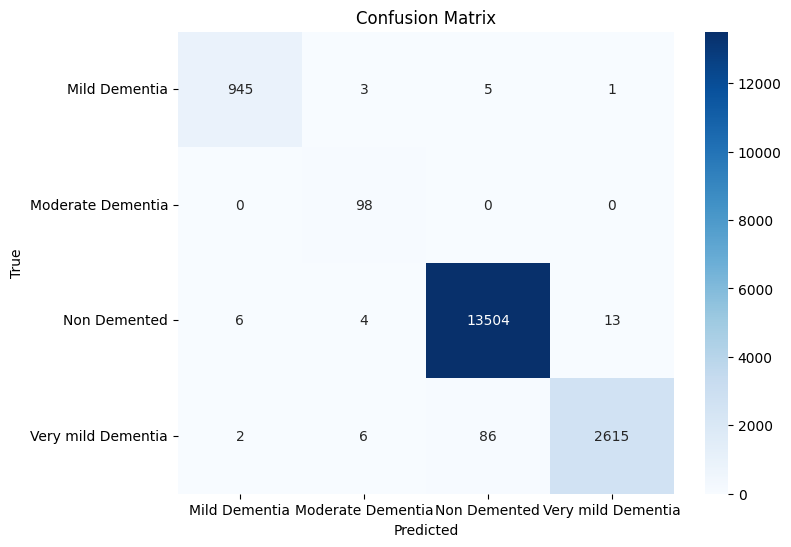

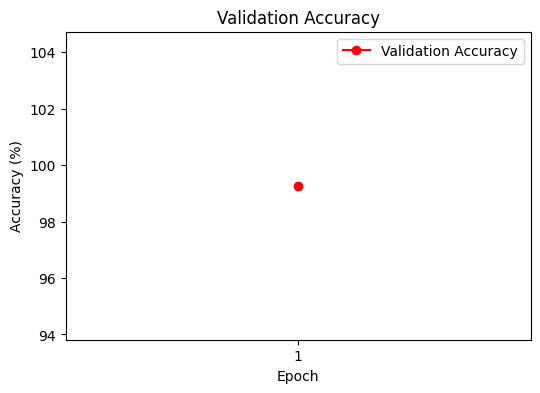

In [11]:
# Install additional dependencies if not already installed
!pip install matplotlib seaborn scikit-learn --quiet

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming these are available from your previous run:
# - model: The trained SiameseNetwork
# - val_loader: Validation DataLoader
# - device: The torch.device (e.g., 'cuda' or 'cpu')

# Step 1: Evaluate the model on the validation set and collect predictions
model.eval()
all_preds = []
all_labels = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    correct = 0
    total = 0
    for imgs, labels in val_loader:
        if imgs is None:
            continue
        imgs, labels = imgs.to(device), labels.to(device)
        outputs, _ = model(imgs, imgs)  # Self-pair for simplicity
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = 100 * correct / total if total > 0 else 0
print(f'Accuracy on validation set: {val_accuracy:.2f}%')

# Step 2: Compute and plot the confusion matrix
class_names = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Step 3: Plot validation accuracy (single point since we only compute it once)
epochs = [1]  # Single epoch for the final validation
val_accuracies = [val_accuracy]  # Single accuracy value

plt.figure(figsize=(6, 4))
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)
plt.legend()
plt.show()